Credits: Federico Luca Facchinetti

# Richards equation

In this tutorial we present how to solve a Richards equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$K$ the matrix conductivity, we want to solve the following problem: find $({q}, \psi)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

The water content $\theta(\psi)$ and the conductivity tensor $K(\psi)$ can be modelled using the van Genuchten model:
$$
\theta(\psi) = \theta_{R} + \frac{\theta_{S} - \theta_{R}}{\left[ 1 + \left( -\alpha \psi \right)^n \right]^{\frac{n-1}{n} }}
$$

$$
K(\psi) = \left( \hat{\theta}(\psi) \right)^{\frac{1}{2}} K_S \left[ 1 - \left( 1 - \hat{\theta}(\psi)^{\frac{n}{n-1}} \right)^{\frac{n-1}{n}} \right]^2 {{{I}}}
$$
where $\hat{\theta}(\psi) = \frac{\theta(\psi) - \theta_{R}}{\theta_{S} - \theta_{R}}$. Both expressions hold only if $\psi \leq 0$. If $\psi > 0$ at ${x} \in \Omega$, the porous medium is fully saturated by the wetting fluid in that point and, thus, $\theta(\psi)=\theta_S$ and $K(\psi)=K_S {{{I}}}$.

### Solution strategy

The weak formulation of the problem will read:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
\left( K^{-1}(\psi) {q}, {v} \right)_{\Omega} - \left( \psi, \nabla \cdot {v} \right)_{\Omega} = - \left( {\nabla} z, {v} \right)_{\Omega} - \left( \hat{\psi}, {v} \cdot \nu \right)_{\Gamma_D} \\
\left(\partial_t \theta (\psi), v \right)_{\Omega} + (\nabla \cdot {q}, v)_{\Omega} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

We will use the Backward Euler discretization scheme to discretize the equation in time:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
\left( K^{-1}(\psi^{n+1}) {q}^{n+1}, {v} \right)_{\Omega} - \left( \psi^{n+1}, \nabla 
\cdot {v} \right)_{\Omega} = - \left( {\nabla} z, {v} \right)_{\Omega} - \left( \hat{\psi}^{n+1}, {v} \cdot \nu \right)_{\Gamma_D} \\
\left(\theta(\psi^{n+1}) , v \right)_{\Omega}  +  \Delta t^{n+1}
(\nabla \cdot {q}^{n+1}, v)_{\Omega} = \left(\theta(\psi^{n}) , v \right)_{\Omega}
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

In order to solve the problem, we will firstly have to deal with the non-linear terms. To do that, we will employ the Picard scheme and linearize the storage term as
$$
\theta(\psi_{k+1}^{n+1}) = \theta(\psi_k^{n+1}) + \theta^{\prime}(\psi_k^{n+1}) (\psi_{k+1}^{n+1} - \psi_k^{n+1})
$$
obtaining:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
\left( K^{-1}(\psi^{n+1}_k) {q}^{n+1}_{k+1}, {v} \right)_{\Omega} - \left( \psi^{n+1}_{k+1}, \nabla \cdot {v} \right)_{\Omega} = - \left( {\nabla} z, {v} \right)_{\Omega} - \left( \hat{\psi}^{n+1}, {v} \cdot \nu \right)_{\Gamma_D} \\
\left( \theta^{\prime}(\psi^{n+1}_{k}) \psi^{n+1}_{k+1}, v \right)_{\Omega} + \Delta t^{n+1} (\nabla \cdot {q}^{n+1}_{k+1}, v)_{\Omega} = \left( \theta^{\prime}(\psi^{n+1}_{k}) \psi^{n+1}_{k}, v \right)_{\Omega} + \left(\theta(\psi^{n}) , v \right)_{\Omega} - \left(\theta(\psi^{n+1}_k) , v \right)_{\Omega}
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

The space discretization is perfomed using the MFEM ($\mathbb{RT}_{0}$ elements for ${q}$ and $\mathbb{P}_0$ for $\psi$). The resulting linear system that must be solved for each step and each iteration is:
$$
\left(
\begin{array}{cc} 
M({\psi^{n+1}_k}) & B^T\\
- \Delta t^{n+1}B & N_{\psi}(\psi^{n+1}_k)
\end{array}
\right)
\left(
\begin{array}{c} 
{q^{n+1}_{k+1}}\\ 
{\psi^{n+1}_{k+1}}\\
\end{array}
\right)
=\left(
\begin{array}{c} 
{Z} + {BC}^{n+1}\\ 
N_\psi(\psi^{n+1}_k) {\psi^{n+1}_k} + \Theta^n - \Theta^{n+1}_k
\end{array}
\right)
$$
where $[M({\psi^{n+1}_k})]_{ij} = \left(K^{-1}(\psi^{n+1}_k) {v}_j, {v}_i \right)_{\Omega}$ and $[N_{\psi}(\psi^{n+1}_k)]_{ij} = 
\left(\theta^{\prime}(\psi^{n+1}_{k})w_j, w_i \right)_{\Omega}$. According to the expression given above of $\theta$ we have
$$
\theta^\prime(\psi) = (n-1)\alpha(-\alpha\psi)^{n-1} \frac{\theta_S-\theta_R}{[1+(-\alpha\psi)^n]^{\frac{2n-1}{n}}}
$$

The stopping criteria for the non-linear solver is:
$$
|{\psi}_{k+1}^{n+1} - {\psi}_{k}^{n+1}| \leq \epsilon_{A} + \epsilon_{R} |{\psi}_{k}^{n+1}|
$$
where $\epsilon_{A}$ and $\epsilon_{R}$ are the absolute and relative error tolerances.

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

Consider the two scenarios:

* $\psi_0 = -2$, $\psi_{top} = 1$ and everywhere else zero flux
* $\psi_0 = 1$, $\psi_{top} = -2$ and everywhere else zero flux

and study the convergence properties of the presented scheme.

### Import and parameters

In [1]:
import numpy as np
import scipy.sparse as sps

import porepy as pp
import pygeon as pg

In [2]:
# Set the maximum number of iterations of the non-linear solver
K = 50

# Set the mesh refinement
N = 20

# Set the number of steps (excluding the initial condition)
num_steps = 9

# Simulation time length
T = 9 / 24

# Fluid density
rho = 1000

# Relative and absolute tolerances for the non-linear solver
abs_tol = 1e-4
rel_tol = 1e-4

# Output directory
output_directory = "ex1"

In [3]:
# Van Genuchten model parameters ( relative permeability model )
theta_s = 0.396
theta_r = 0.131

alpha = 0.423

n = 2.06
K_s = 4.96e-2

m = 1 - 1 / n

# Time step
dt = (T - 0) / num_steps

We now define the function $\theta$.

Text(0, 0.5, "theta'")

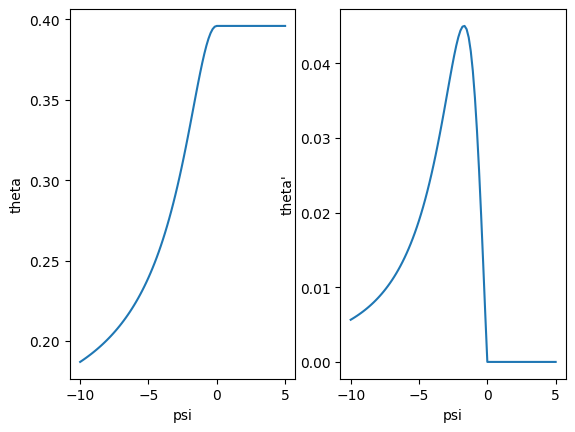

In [4]:
# Theta function
theta_expr = lambda psi: theta_r + (theta_s - theta_r) / np.power(
    1 + np.power(-alpha * psi, n), m
)


def theta(psi):
    mask = np.where(psi < 0)
    res = np.ones_like(psi) * theta_s
    res[mask] = theta_expr(psi[mask])

    return res


theta_prime_expr = (
    lambda psi: (n - 1)
    * alpha
    * np.power(-alpha * psi, n - 1)
    * (theta_s - theta_r)
    / np.power(1 + np.power(-alpha * psi, n), (2 * n - 1) / n)
)


# Theta prime function
def theta_prime(psi):
    mask = np.where(psi < 0)
    res = np.zeros_like(psi)
    res[mask] = theta_prime_expr(psi[mask])

    return res

#TODO: plot the curves

And now the function for $K$.

Text(0, 0.5, 'K')

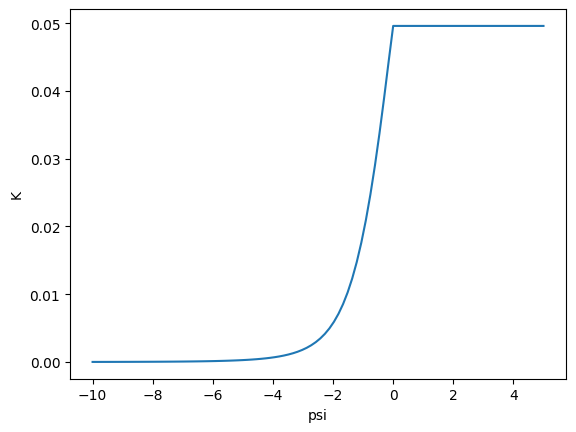

In [5]:
# K function
eff_sat = lambda psi: (theta_expr(psi) - theta_r) / (theta_s - theta_r)
conductivity_expr = (
    lambda psi: K_s
    * np.sqrt(eff_sat(psi))
    * np.square(1 - np.power(1 - np.power(eff_sat(psi), 1 / m), m))
)


def conductivity(psi):
    mask = np.where(psi < 0)
    res = np.ones_like(psi) * K_s
    res[mask] = conductivity_expr(psi[mask])

    return res

#TODO: plot the curves

### Domain preparation

In [6]:
# Prepare the domain and its mesh
sd = pp.StructuredTriangleGrid([N] * 2, [1] * 2)

sd.compute_geometry()

In [7]:
key = "flow"

# Collection of boundary conditions
bc_value = []
bc_essential = []

# Initial pressure
psi_0 = []

# Discretizations for q and \psi
RT0 = pg.RT0(key)
P0 = pg.PwConstants(key)

In [8]:
# Prepare the gravity term Z by firstly projecting g_func into the RT0 space and then by
# multiplying it by the RT0 mass matrix
g_proj = RT0.interpolate(sd, lambda _: np.array([0, -1, 0]))
gravity = RT0.assemble_mass_matrix(sd) @ g_proj

# Prepare the initial pressure term by interpolating initial_pressure_func into the P0 space
psi_0.append(P0.interpolate(sd, lambda _: -2))

top = np.isclose(sd.face_centers[1, :], 1)
bottom = np.isclose(sd.face_centers[1, :], 0)
left = np.isclose(sd.face_centers[0, :], 0)
right = np.isclose(sd.face_centers[0, :], 1)
bc_ess = np.logical_or.reduce((left, right, bottom))

# Set the initial conductivity tensor in data (the actual saved tensor does not matter at this stage)
data = {}
pp.initialize_data(
    sd,
    data,
    key,
    {
        "second_order_tensor": pp.SecondOrderTensor(np.ones(sd.num_cells)),
    },
)

# Add a lambda function that generates for each time instant the (discretized) natural boundary
# conditions for the problem
bc_value.append(-RT0.assemble_nat_bc(sd, lambda _: 1, top))

# Set the essential boundary conditions (they will be enforced before solving the system)
essential_pressure_dofs = np.zeros(P0.ndof(sd), dtype=bool)
bc_essential = np.hstack((bc_ess, essential_pressure_dofs))

### Matrix assembly

In [9]:
M_psi = P0.assemble_mass_matrix(sd)
B = -M_psi @ pg.div(sd)

# Psi projection
proj_psi = P0.eval_at_cell_centers(sd)
inv_proj_psi = proj_psi.copy()
inv_proj_psi.data = 1 / inv_proj_psi.data

# q projection
proj_q = RT0.eval_at_cell_centers(sd)

dof_psi, dof_q = B.shape

In [10]:
# Assemble initial solution
sol_0 = np.zeros(dof_q + dof_psi)
sol_0[-dof_psi:] += np.hstack(psi_0)

# Final solution list. Each of its elements will be the solution at a specific instant
sol = [sol_0]

In [11]:
# Assemble the fixed part of the right hand side (rhs)
fixed_rhs = np.zeros(dof_q + dof_psi)
fixed_rhs[:dof_q] = gravity + np.hstack(bc_value)

### Solving stage

In [12]:
# Helper function to export the current_sol to a file
def export_solution(saver, current_sol, num_step):
    ins = list()

    cell_q = (proj_q @ current_sol[:dof_q]).reshape((3, -1), order="F")
    cell_psi = proj_psi @ current_sol[dof_q : (dof_q + dof_psi)]
    cell_theta = theta(cell_psi)
    cell_s = cell_theta / theta_s

    ins.append((sd, "cell_q", cell_q))
    ins.append((sd, "cell_psi", cell_psi))
    ins.append((sd, "cell_theta", cell_theta))
    ins.append((sd, "cell_s", cell_s))

    saver.write_vtu(ins, time_step=num_step)

In [13]:
# Prepare the porepy exporter and export the initial solution
saver = pp.Exporter(sd, "sol", folder_name=output_directory)

export_solution(saver, current_sol=sol[-1], num_step=0)

In [14]:
# TODO: implement the time and nonlinear loopp
# Time loop
for time_step in np.arange(num_steps):
    current_time = (time_step + 1) * dt
    print("Time " + str(round(current_time, 5)))

    # TODO Rhs that changes with time (but not with k)

    # Add \Theta^n:
    # 1. Convert psi DOF to cell-wise values
    # 2. Compute theta
    # 3. Project it to P0 elements
    # 4. Multiply by psi-mass
  
    time_rhs = 

    # Solution at the previous iteration (k=0 corresponds to the solution at the previous time step)
    prev = sol[-1]

    # TODO Non-linear solver
    for k in np.arange(K):
        # Set the conductivity tensor in data (the actual saved tensor does not matter at this stage)
        pp.initialize_data(
            sd,
            data,
            key,
            {
                "second_order_tensor": pp.SecondOrderTensor(
                    conductivity(proj_psi @ prev[-dof_psi:])
                ),
            },
        )

        # TODO Assemble the matrices that depend on the iteration
        M = 
        N_psi = 

        # TODO Actual rhs
        rhs = 

        # TODO Assemble the system to be solved at time n and interation k
        spp = sps.bmat([], format="csc")

        # Prepare the linear solver
        ls = pg.LinearSystem(spp, rhs)

        # Fix the essential boundary conditions
        ls.flag_ess_bc(np.hstack(bc_essential), np.zeros(dof_q + dof_psi))

        # Solve the system
        current = ls.solve()

        # TODO implement stopping criterion
  
        if #condition
            prev = current.copy()
        else:
            break

    sol.append(current)
    export_solution(saver, current_sol=sol[-1], num_step=(time_step + 1))

saver.write_pvd(dt * np.arange(num_steps + 1))

Time 0.04167
Iteration #10, error L2 relative psi: 0.00023580858665436834
Time 0.08333
Iteration #8, error L2 relative psi: 0.0002267224465214702
Time 0.125
Iteration #8, error L2 relative psi: 0.00012321804968193074
Time 0.16667
Iteration #8, error L2 relative psi: 7.865614295593626e-05
Time 0.20833
Iteration #7, error L2 relative psi: 0.00011217413460586274
Time 0.25
Iteration #6, error L2 relative psi: 0.00010747090284224937
Time 0.29167
Iteration #4, error L2 relative psi: 0.0
Time 0.33333
Iteration #2, error L2 relative psi: 0.0
Time 0.375
Iteration #1, error L2 relative psi: 0.0
